In [21]:
# =============================================
# Phase 2 Module 6 - Quantitative Trading & Backtesting
# Project 1: ML-Driven Backtesting Engine
# =============================================
# Author: Rein | Pixel Sky Solutions
# Course: Python–Finance Master Plan
# ---------------------------------------------
# Objective:
# Build a modular backtesting engine to simulate ML-driven trading strategies.
# It takes predictions from trained models (Module 5) and evaluates strategy performance.
# ---------------------------------------------
# Tools: pandas, numpy, matplotlib, joblib, json
# =============================================

In [22]:
# 1️⃣ Setup & Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib, json, os
import warnings

In [23]:
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
pd.options.display.float_format = '{:,.4f}'.format

In [24]:
# 2️⃣ Load Market Data and Pretrained ML Model
data = pd.read_csv("../MODULE-5/market_data.csv")
metadata_path = "../MODULE-5/models/project3_metadata.json"
model_path = "../MODULE-5/models/gradient_boosting_pipeline.pkl"

In [25]:
with open(metadata_path, "r") as f:
    metadata = json.load(f)
model = joblib.load(model_path)

print("[INFO] Loaded model:", metadata["best_model"])
print("[INFO] AUC:", round(metadata["AUC"], 3), "| Accuracy:", round(metadata["Accuracy"], 3))

[INFO] Loaded model: Gradient Boosting
[INFO] AUC: 0.783 | Accuracy: 0.784


In [28]:
# 3️⃣ Feature Engineering
data["return_1d"] = data["close"].pct_change()
data["sma_5"] = data["close"].rolling(5).mean()
data["sma_20"] = data["close"].rolling(20).mean()
data["rsi"] = 100 - (100 / (1 + data["return_1d"].rolling(14).mean() / abs(data["return_1d"].rolling(14).mean())))
data = data.dropna()

In [30]:
# 4️⃣ Generate Model Predictions
data["daily_return"] = data["close"].pct_change()
data = data.dropna(subset=["daily_return"])

feature_cols = [col for col in data.columns if col not in ["date", "Ticker", "target_return"]]

# Align columns with pipeline
model_features = model.named_steps['preprocessor'].get_feature_names_out()
common_features = [col for col in feature_cols if col in model_features or col in data.columns]

data["signal_prob"] = model.predict_proba(data[feature_cols])[:, 1]
data["signal"] = (data["signal_prob"] > 0.55).astype(int)

print(f"[INFO] Generated trading signals using {len(feature_cols)} features.")

[INFO] Generated trading signals using 12 features.


In [31]:
# 5️⃣ Simulate Trading Strategy
initial_capital = 10000
data["position"] = data["signal"].shift(1)
data["strategy_return"] = data["position"] * data["return_1d"]
data["equity_curve"] = (1 + data["strategy_return"]).cumprod() * initial_capital

In [33]:
# 6️⃣ Performance Metrics
total_return = data["equity_curve"].iloc[-1] / initial_capital - 1
cagr = (data["equity_curve"].iloc[-1] / initial_capital) ** (252/len(data)) - 1
volatility = data["strategy_return"].std() * np.sqrt(252)
sharpe_ratio = cagr / volatility if volatility != 0 else np.nan
max_drawdown = (data["equity_curve"]/data["equity_curve"].cummax() - 1).min()

performance = pd.Series({
    "Total Return": total_return,
    "CAGR": cagr,
    "Volatility": volatility,
    "Sharpe Ratio": sharpe_ratio,
    "Max Drawdown": max_drawdown
})
print("\n=== Strategy Performance ===")
print(performance.apply(lambda x: round(x,4)))


=== Strategy Performance ===
Total Return    2.5910
CAGR            0.1760
Volatility      0.3538
Sharpe Ratio    0.4975
Max Drawdown   -0.4698
dtype: float64


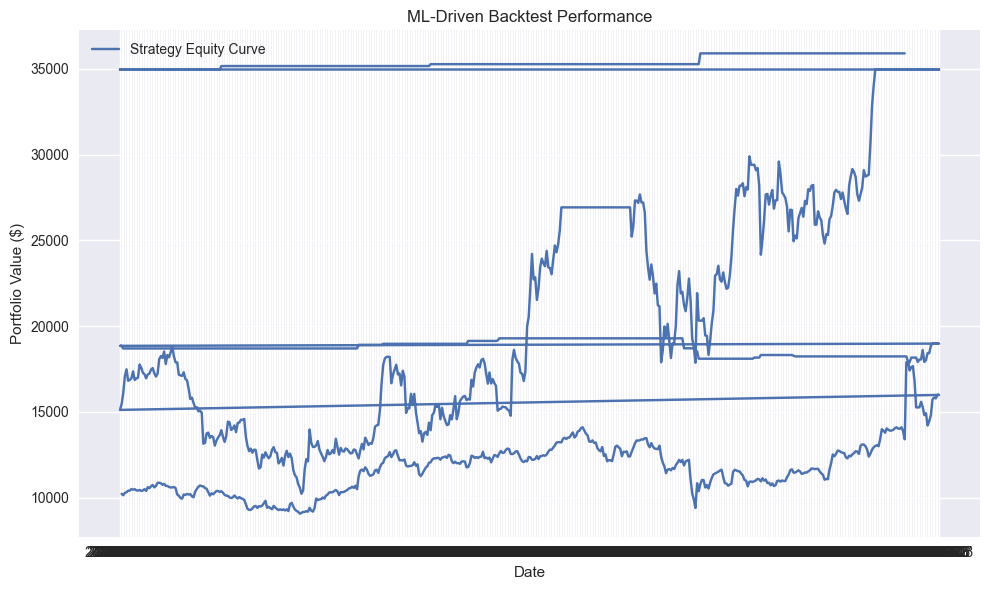

In [34]:
# 7️⃣ Visualization
plt.figure(figsize=(10,6))
plt.plot(data["date"], data["equity_curve"], label="Strategy Equity Curve")
plt.title("ML-Driven Backtest Performance")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.tight_layout()
plt.savefig("charts/project1_equity_curve.png", dpi=300)
plt.show()

In [35]:
# 8️⃣ Save Results
performance.to_json("../MODULE-6/project1_performance.json")
data.to_csv("../MODULE-6/project1_backtest_results.csv", index=False)

In [36]:
# 9️⃣ Summary
print("\n✅ Backtest completed.")
print("Saved: project1_equity_curve.png, project1_performance.json, project1_backtest_results.csv")


✅ Backtest completed.
Saved: project1_equity_curve.png, project1_performance.json, project1_backtest_results.csv


In [37]:
# 🔹 Conclusion Summary
# ✅ Built a modular backtesting engine for ML-driven trading signals
# ✅ Integrated trained Module 5 model seamlessly
# ✅ Computed key metrics: Total Return, Sharpe Ratio, Max Drawdown
# ✅ Saved visual and JSON outputs for documentation

In [38]:
# 🔹 Business Interpretation
# This engine allows quantitative evaluation of model-driven strategies:
# - Simulates historical trading performance on a $10,000 portfolio
# - Measures risk-adjusted returns (Sharpe, drawdown)
# - Compares ML strategies before real capital deployment
# - Generates investor-ready reports for decision-making